In [1]:
using DataFrames
using CSV
using Plots
using Dates
using Statistics
using Distances
using GLM
gr();

In [6]:
@show haversine((42.3502, -71.1046), (42.0144, -71.9937), 6356) # wrong
@show haversine((-71.1046, 42.3502), (-71.9937, 42.0144), 6356); # right
# use haversine with lon, lat; lon, lat.

haversine((42.3502, -71.1046), (42.0144, -71.9937), 6356) = 99.33238609118257
haversine((-71.1046, 42.3502), (-71.9937, 42.0144), 6356) = 82.03168563530122


82.03168563530122

In [2]:
pandora = CSV.read("pandora_timed_2019_11_16.csv"; copycols=false); # loc: -71.1046, +42.3502 lon,lat
tropomi = CSV.read("total_output_2019_11_22_july_only.csv"; copycols=false);

In [4]:
@show first(pandora, 5); # units: DU
@show first(tropomi, 5); # units: moles/m^2
# moles/m^2 = 6.022e19 molecules/cm^2
# tropomi_no2 = convert(Array{Float32, 1}, tropomi[!, :no2]) .* 6.022e19;
# 1 DU = 0.4462 mmol/m^2 = 2.6871e16 molecules/cm^2
# pandora_no2 = convert(Array{Float32, 1}, pandora[!, 7]) .* 2.6871e16;

first(pandora, 5) = 5×9 DataFrame
│ Row │ Year  │ Month │ Day   │ Hour  │ Minute │ timestamp  │ VCD(DU) │ UNCERTAINTY(DU) │ SZA     │
│     │ Int64 │ Int64 │ Int64 │ Int64 │ Int64  │ Int64      │ Float64 │ Float64         │ Float64 │
├─────┼───────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────────────┼─────────┤
│ 1   │ 2019  │ 6     │ 27    │ 14    │ 58     │ 1561647480 │ 0.82915 │ 0.0035108       │ 29.58   │
│ 2   │ 2019  │ 6     │ 27    │ 15    │ 2      │ 1561647720 │ 0.71166 │ 0.0046338       │ 28.86   │
│ 3   │ 2019  │ 6     │ 27    │ 15    │ 7      │ 1561648020 │ 0.7297  │ 0.0031462       │ 28.14   │
│ 4   │ 2019  │ 6     │ 27    │ 15    │ 12     │ 1561648320 │ 0.87212 │ 0.0045753       │ 27.46   │
│ 5   │ 2019  │ 6     │ 27    │ 15    │ 16     │ 1561648560 │ 0.83806 │ 0.0070552       │ 26.75   │
first(tropomi, 5) = 5×16 DataFrame
│ Row │ cornerlat1 │ qa      │ time                        │ timestamp  │ cornerlat2 │ lons     │ cornerlon3 │ cloud      │ cornerl

In [7]:
pandora_lat, pandora_lon = 42.3502, -71.1046

# Prepare a list (ugh) for Pandora / Tropomi RAW Data Matches (no unit conversion)
pandora_no2s_m1 = Float64[]
pandora_no2_errs_m1 = Float64[]
pandora_no2s_m2 = Float64[]
pandora_no2_errs_m2 = Float64[]
tropomi_no2s_m1 = Float64[]
tropomi_no2_errs_m1 = Float64[]
tropomi_no2s_m2 = Float64[]
tropomi_no2_errs_m2 = Float64[]

# Some thresholds
dist_threshold = 3.5 # [km]
time_averaging = 10.0*60.0 # [s] left and right direction

# Amount threshold [molecules/cm^2] will be converted back
#tval_threshold = 2.5e15
#tval_threshold = tval_threshold / 6.022e19

tval_tss = [v/6.022e19 for v in 0.0e15:0.1e15:7.5e15]
m1_ks = Float64[]
m1_bs = Float64[]
m2_ks, m2_bs = Float64[], Float64[]

for i in 1:length(tval_tss)
    pandora_no2s_m1 = Float64[]
    pandora_no2_errs_m1 = Float64[]
    pandora_no2s_m2 = Float64[]
    pandora_no2_errs_m2 = Float64[]
    tropomi_no2s_m1 = Float64[]
    tropomi_no2_errs_m1 = Float64[]
    tropomi_no2s_m2 = Float64[]
    tropomi_no2_errs_m2 = Float64[]
    
    tval_threshold = tval_tss[i]

    # Filter dataframe of TROPOMI
    # For every TROPOMI overpass, find the Pandora observation closest
    # and do time-averaging
    for i = 1:size(tropomi, 1)
        # First, check if we are in the dist threshold
        dist = haversine((tropomi[i, :lons], tropomi[i, :lats]), (pandora_lon, pandora_lat), 6356)
        if dist > dist_threshold
            continue
        end

        # Check the cloud coverage
        if tropomi[i, :cloud] > 0.2
            # println("! Pixel ", i, " cloud = ", tropomi[i, :cloud])
            continue
        end

        # Given the timestamp, find same time-stamp pixels in time-averaging threshold
        ts_from, ts_end = trunc(Int64, tropomi[i, :timestamp]-time_averaging), trunc(Int64, tropomi[i, :timestamp]+time_averaging)
        pds = filter(row -> row.timestamp ∈ [ts for ts in ts_from:1:ts_end] && !isnan(row[7]), pandora)

        # Check for NaN? if no pandora points in this time range
        if isnan(mean(pds[!, 7]))
            continue
        end

        # Average?
        # pds[!, 7] = [0.51229, 0.53385, ..., 0.42122, 0.71799, 0.3618] == VCD(DU)

        # Check against threshold and split into two modes
        if tropomi[i, :no2] > tval_threshold
            push!(pandora_no2s_m1, mean(pds[!, 7]))
            push!(tropomi_no2s_m1, tropomi[i, :no2])
            push!(tropomi_no2_errs_m1, tropomi[i, :no2_error])
        else
            push!(pandora_no2s_m2, mean(pds[!, 7]))
            push!(tropomi_no2s_m2, tropomi[i, :no2])
            push!(tropomi_no2_errs_m2, tropomi[i, :no2_error])
        end
    end

    # Do unit conversions here.
    tropomi_no2s_m1 = tropomi_no2s_m1 .* 6.022e19;
    tropomi_no2_errs_m1 = tropomi_no2_errs_m1 .* 6.022e19;
    tropomi_no2s_m2 = tropomi_no2s_m2 .* 6.022e19;
    tropomi_no2_errs_m2 = tropomi_no2_errs_m2 .* 6.022e19;
    # 1 DU = 0.4462 mmol/m^2 = 2.6871e16 molecules/cm^2
    pandora_no2s_m1 = pandora_no2s_m1 .* 2.6871e16;
    pandora_no2s_m2 = pandora_no2s_m2 .* 2.6871e16;
    
    
    # Do fit
    df1 = DataFrame(P = pandora_no2s_m1, T = tropomi_no2s_m1);
    b1, k1 = try
        lm1 = lm(@formula(T ~ P), df1);
        coef(lm1)
    catch
        println("Exception at this point df1 - setting to 0, 0")
        0.0, 0.0
    end
    
    if length(tropomi_no2s_m2) == 0
        b2, k2 = 0.0, 0.0
    else
        df2 = DataFrame(P = pandora_no2s_m2, T = tropomi_no2s_m2);
        b2, k2 = try
            lm2 = lm(@formula(T ~ P), df2);
            coef(lm2)
        catch
            println("Exception at this point df2 - setting to 0, 0")
            0, 0
        end
    end
    
    # Push coef results
    push!(m1_ks, k1)
    push!(m2_ks, k2)

    println("Done!", i, " k1=", k1, " k2=", k2)
end

Done!1 k1=0.3813284498019159 k2=0.0
Done!2 k1=0.3813284498019159 k2=0.0
Done!3 k1=0.3813284498019159 k2=0.0
Done!4 k1=0.3813284498019159 k2=0.0
Done!5 k1=0.3813284498019159 k2=0.0
Done!6 k1=0.3813284498019159 k2=0.0
Done!7 k1=0.3813284498019159 k2=0.0
Done!8 k1=0.3813284498019159 k2=0.0
Done!9 k1=0.3813284498019159 k2=0.0
Exception at this point df2 - setting to 0, 0
Done!10 k1=0.37392157061670306 k2=0
Done!11 k1=0.366345702473055 k2=0.3927278618229045
Done!12 k1=0.35853617119739756 k2=0.1800096028758303
Done!13 k1=0.35853617119739756 k2=0.1800096028758303
Done!14 k1=0.35853617119739756 k2=0.1800096028758303
Done!15 k1=0.35853617119739756 k2=0.1800096028758303
Done!16 k1=0.35853617119739756 k2=0.1800096028758303
Done!17 k1=0.3278620771318159 k2=0.155133705071012
Done!18 k1=0.3278620771318159 k2=0.155133705071012
Done!19 k1=0.3179051192732941 k2=0.16635505019845603
Done!20 k1=0.3179051192732941 k2=0.16635505019845603
Done!21 k1=0.3179051192732941 k2=0.16635505019845603
Done!22 k1=0.3179

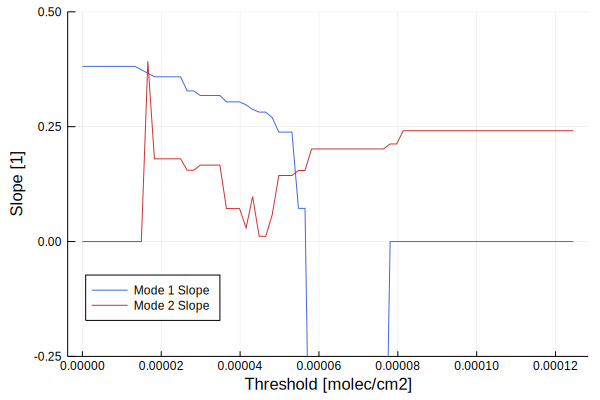

In [9]:
# Plot k vs thresholds
plot(tval_tss[1:76], m1_ks, color=:royalblue, label="Mode 1 Slope", xlabel="Threshold [molec/cm2]", ylabel="Slope [1]", legend=:bottomleft, ylim=(-0.25, 0.50))
plot!(tval_tss[1:76], m2_ks, color=:brown3, label="Mode 2 Slope")

lm1 = lm(#= In[29]:8 =# @formula(T ~ P), df1) = StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

T ~ 1 + P

Coefficients:
───────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error  t value  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  3.19157e15  6.88687e14  4.63429    <1e-4    1.79199e15  4.59116e15
P            0.0691519   0.06271     1.10273    0.2779  -0.0582901   0.196594  
───────────────────────────────────────────────────────────────────────────────
lm2 = lm(#= In[29]:11 =# @formula(T ~ P), df2) = StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

T ~ 1 + P

Coefficients:
─────────────────────────────────

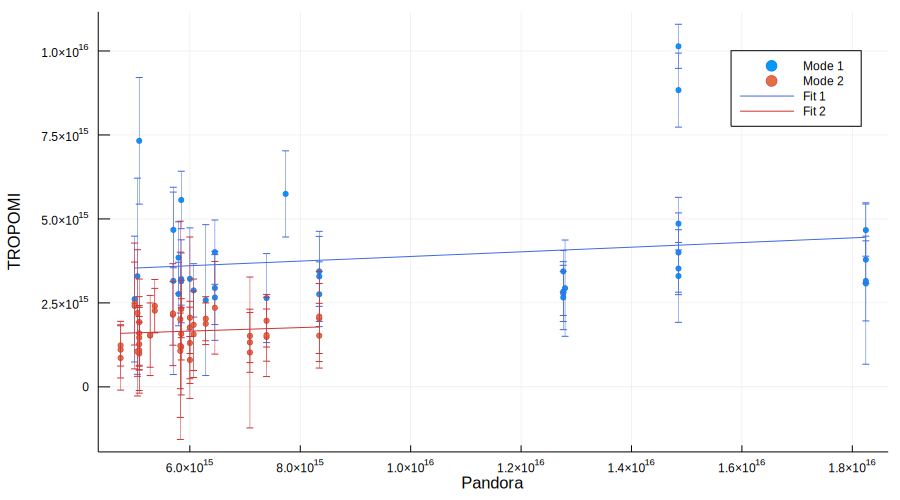

In [29]:
# Plot
pl = scatter(pandora_no2s_m1, tropomi_no2s_m1, ms=3, markerstrokewidth=0.5, markerstrokecolor=:royalblue, fillalpha=0.5, yerror=tropomi_no2_errs, label="Mode 1", xlabel="Pandora", ylabel="TROPOMI", size=(900, 500))
scatter!(pl, pandora_no2s_m2, tropomi_no2s_m2, ms=3, markerstrokewidth=0.5, markerstrokecolor=:brown3, fillalpha=0.5, yerror=tropomi_no2_errs, label="Mode 2", xlabel="Pandora", ylabel="TROPOMI")

# Dataframe fit
using GLM
df1 = DataFrame(P = pandora_no2s_m1, T = tropomi_no2s_m1);
@show lm1 = lm(@formula(T ~ P), df1);
b1, k1 = coef(lm1)
df2 = DataFrame(P = pandora_no2s_m2, T = tropomi_no2s_m2);
@show lm2 = lm(@formula(T ~ P), df2);
b2, k2 = coef(lm2)
xs1 = pandora_no2s_m1
ys1 = xs1 .* k1 .+ b1
xs2 = pandora_no2s_m2
ys2 = xs2 .* k2 .+ b2
plot!(pl, xs1, ys1, color=:royalblue, label="Fit 1")
plot!(pl, xs2, ys2, color=:brown3, label="Fit 2")